In [1]:
import os; import sys ; import matplotlib as mpl ; import matplotlib.pyplot as plt ; import numpy as np ; from flopy.plot.styles import styles
import pathlib; from pathlib import Path; import pandas as pd; import flopy ; from modflow_devtools.misc import get_env, timed
from pprint import pformat; import csv ; from flopy.utils.util_array import read1d ; from PIL import Image
write = get_env("WRITE", True) ; run = get_env("RUN", True) ;  plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True) ; plot_save = get_env("PLOT_SAVE", True)

In [2]:
example_name = "ex-gwt-mt3dms-p09"
exe_name = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6'
current_directory = os.getcwd();  print(current_directory)

E:\15_REPOS\00_BETAMI\01_MT3D_Zjeng_


In [3]:
path = pathlib.Path('E:\\15_REPOS\\00_BETAMI\\98_Plus\\02_MT3D')
path.mkdir(parents=True, exist_ok=True); os.chdir(path); current_directory = os.getcwd()
directory_name = 'ex-RES'    ; workspace = os.path.join('.', directory_name)
if os.path.isdir(workspace) is False:
    os.mkdir(workspace)                         
output_folder = Path('./p09_mf6') ; output_folder.mkdir(exist_ok=True)          # sim_name = directory_name

In [ ]:
sim_name = "ex-gwt-mt3dms-p09" ; output_folder = Path("./05_ex-gwf-fhb") ; output_folder.mkdir(exist_ok=True) ; example_name=sim_name
parameter_units = {"recharge": "$ft/s$"}  ; length_units = "feet"  ; time_units = "seconds" 
exe_name = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf6.exe' ; workspace = output_folder 

In [4]:
# Parameters
length_units = "meters" ; time_units = "seconds" ; nlay=1;
nrow=18;ncol=14;delr=100.0;delc=100.0;delz=10.0;top=0.0;prsity=0.3  ;k1=1.474e-4;  k2=1.474e-7  ;inj=0.001;ext=-0.0189;al=20.0;trpt=0.2;perlen=2.0;

hk = k1 * np.ones((nlay, nrow, ncol), dtype=float)                        ; hk[:, 5:8, 1:8]  = k2       ; laytyp = icelltype = 0
ibound = np.ones((nlay, nrow, ncol), dtype=int)    ; ibound[0, 0, :] = -1 ; ibound[0, -1, :] = -1
idomain = np.ones((nlay, nrow, ncol), dtype=int)   ; icbund = 1

qwell1 = 0.001 ; qwell2 = -0.0189 ; welspd = {0: [[0, 3, 6, qwell1], [0, 10, 6, qwell2]]}  ; cwell1 = 57.87 ; cwell0 = 0.0   

wellist_sp1 = [] ; wellist_sp1.append([(0, 3, 6), qwell1, cwell1]) ;  wellist_sp1.append([(0, 10, 6), qwell2, cwell0])    # MF6
wellist_sp2 = [] ; wellist_sp2.append([(0, 3, 6), qwell1, cwell0]) ;  wellist_sp2.append([(0, 10, 6), qwell2, cwell0])    # Injection /  Pumping 
spd_mf6 = {0: wellist_sp1, 1: wellist_sp2}

sconc = 0.0 ; ath1 = al * trpt ; dmcoef = 0.0 ; perlen = [365.0 * 86400, 365.0 * 86400] ; steady = [False, False] ; nper = len(perlen)
nstp = [365, 365] ;  tsmult = [1.0, 1.0]  ; sconc = 0.0 ; c0 = 0.0 ; botm = [top - delz] ; mixelm = -1

nouter, ninner = 100, 300 ; hclose, rclose, relax = 1e-6, 1e-6, 1.0 ; percel = 1.0 ; itrack = 2 ; wd = 0.5 ; dceps = 1.0e-5 ; 
nplane = 0 ; npl = 0 ; nph = 16 ; npmin = 2 ; npmax = 32 ; dchmoc = 1.0e-3 ; nlsink = nplane ; npsink = nph ; nadvfd = 1

In [5]:
def build_models(sim_name, mixelm=0, silent=False):
    name = "p09-mf6"  ;    gwfname = "gwf-" + name
    sim_ws = os.path.join(output_folder, sim_name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name="mf6")
    tdis_rc = []
    for i in range(nper):
        tdis_rc.append((perlen[i], nstp[i], tsmult[i]))
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata = tdis_rc, time_units=time_units)   # tdis_rc
    gwf    = flopy.mf6.ModflowGwf(sim,modelname=gwfname,save_flows=True,model_nam_file=f"{gwfname}.nam")
    imsgwf = flopy.mf6.ModflowIms(sim,print_option="SUMMARY",outer_dvclose=hclose,outer_maximum=nouter,under_relaxation="NONE",
                                  inner_maximum=ninner,inner_dvclose=hclose,rcloserecord=rclose,linear_acceleration="CG",
                                  scaling_method="NONE",reordering_method="NONE",relaxation_factor=relax,filename=f"{gwfname}.ims")
    sim.register_ims_package     (imsgwf, [gwf.name])                      # MF6_____________________________________________________________________
    flopy.mf6.ModflowGwfdis      (gwf,length_units=length_units,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm,
                                  idomain=idomain,filename=f"{gwfname}.dis")
    
    strt = np.zeros((nlay, nrow, ncol), dtype=float)  ; strt[0, 0, :] = 250.0  ;    xc = gwf.modelgrid.xcellcenters  # (MT3D_MF5)
    for j in range(ncol):
        strt[0, -1, j] = 20.0 + (xc[-1, j] - xc[-1, 0]) * 2.5 / 100
    flopy.mf6.ModflowGwfic(gwf, strt=strt, filename=f"{gwfname}.ic")
    
    flopy.mf6.ModflowGwfnpf(gwf,save_flows=False,icelltype=icelltype,k=hk,k33=hk,save_specific_discharge=True,filename=f"{gwfname}.npf") # Lpf mff5
    sto = flopy.mf6.ModflowGwfsto(gwf, ss=1.0e-05)
    chdspd = []
    for j in np.arange(ncol):
        chdspd.append([(0,0,j), 250, 0]) ; hd = 20 + (xc[-1,j]-xc[-1,0])*2.5/100 ; chdspd.append([(0,17,j), hd, 0])  # Top/Bottom boundary
    chdspd = {0: chdspd}
    
    flopy.mf6.ModflowGwfchd  (gwf,maxbound=len(chdspd),   stress_period_data=chdspd,    save_flows=False,    # stress_period_data=chdspd
                              auxiliary="CONCENTRATION",pname="CHD-1",filename=f"{gwfname}.chd")
    flopy.mf6.ModflowGwfwel  (gwf,print_input=True,print_flows=True,stress_period_data=spd_mf6,save_flows=False,
                              auxiliary="CONCENTRATION",pname="WEL-1",filename=f"{gwfname}.wel")
    flopy.mf6.ModflowGwfoc   (gwf,head_filerecord=f"{gwfname}.hds",budget_filerecord=f"{gwfname}.bud",
                              headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
                              saverecord=[("HEAD", "LAST"), ("BUDGET", "LAST")], printrecord=[("HEAD", "LAST"), ("BUDGET", "LAST")])                         
    gwtname = "gwt-" + name
    gwt = flopy.mf6.MFModel(sim,model_type="gwt6",modelname=gwtname,model_nam_file=f"{gwtname}.nam")  ;         gwt.name_file.save_flows = True
    imsgwt = flopy.mf6.ModflowIms(sim,print_option="SUMMARY",outer_dvclose=hclose,outer_maximum=nouter,under_relaxation="NONE",
                                  inner_maximum=ninner,inner_dvclose=hclose,rcloserecord=rclose, linear_acceleration="BICGSTAB",
                                  scaling_method="NONE",reordering_method="NONE",relaxation_factor=relax,filename=f"{gwtname}.ims")                  
    sim.register_ims_package(imsgwt, [gwt.name])
    flopy.mf6.ModflowGwtdis(gwt,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm,idomain=idomain,filename=f"{gwtname}.dis")
    flopy.mf6.ModflowGwtic(gwt, strt=sconc, filename=f"{gwtname}.ic")
    if mixelm >= 0:
        scheme = "UPSTREAM"
    elif mixelm == -1:
        scheme = "TVD"
    else:
        raise Exception()
    flopy.mf6.ModflowGwtadv(gwt, scheme=scheme, filename=f"{gwtname}.adv")
    if al != 0:
         flopy.mf6.ModflowGwtdsp(gwt,xt3d_off=True,alh=al,ath1=ath1,filename=f"{gwtname}.dsp",)
    flopy.mf6.ModflowGwtmst(gwt,porosity=prsity,first_order_decay=False,decay=None,decay_sorbed=None,sorption=None,
                            bulk_density=None,distcoef=None,filename=f"{gwtname}.mst") 
    sourcerecarray = [("WEL-1", "AUX", "CONCENTRATION"),("CHD-1", "AUX", "CONCENTRATION")]
    flopy.mf6.ModflowGwtssm(gwt, sources=sourcerecarray, filename=f"{gwtname}.ssm")
    flopy.mf6.ModflowGwtoc(gwt,budget_filerecord=f"{gwtname}.cbc",concentration_filerecord=f"{gwtname}.ucn",
                           concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
                           saverecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
                           printrecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")], filename=f"{gwtname}.oc")
    flopy.mf6.ModflowGwfgwt(sim,exgtype="GWF6-GWT6",exgmnamea=gwfname,exgmnameb=gwtname,filename=f"{name}.gwfgwt")

#    mf6.simulation_data.mfpath.get_sim_path()
#    gwt = mf6.get_model(list(mf6.model_names)[1])     ; ucnobj_mf6 = gwt.output.concentration()       ; conc_mf6 = ucnobj_mf6.get_alldata()
    
    return sim     #, conc_mf6

def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)
@timed
def run_models(sim, silent=True):
    success, buff = sim.run_simulation(silent=silent, report=True)   ; assert success, pformat(buff)

In [6]:
def plot_results(mf6, idx, ax=None):
    mf6.simulation_data.mfpath.get_sim_path()
    gwt = mf6.get_model(list(mf6.model_names)[1])     ; ucnobj_mf6 = gwt.output.concentration()       ; conc_mf6 = ucnobj_mf6.get_alldata()
    with styles.USGSPlot() as fs:
        sim_name = mf6.name  ; plt.rcParams["lines.dashed_pattern"] = [5.0, 5.0]   ; levels = np.arange(0.2, 10, 0.4)  ; stp_idx = 0  # 1,2
        cflood = np.ma.masked_less_equal(conc_mf6[stp_idx], 0.2)          ; fig = plt.figure(figsize=(5, 3), dpi=200, tight_layout=True)
        mm = flopy.plot.PlotMapView(ax=ax, model=gwt) ; mm.plot_array(hk) ; mm.plot_ibound() ; mm.plot_grid(color=".5", alpha=0.2)
        cs = mm.plot_array(cflood[0], alpha=0.5, vmin=0, vmax=3)          ; cs = mm.contour_array(conc_mf6[stp_idx], colors="k", levels=levels)
        plt.clabel(cs)                        ; plt.xlabel("X(m) ncol delc")        ; plt.ylabel("Y(m) nrow delr")
        title = "MF6-(t=08 years) " + str(stp_idx + 1)   ; letter = chr(ord("@") + idx + 2)   ; styles.heading(letter=letter, heading=title)
        plt.show()

run_models took 966.55 ms


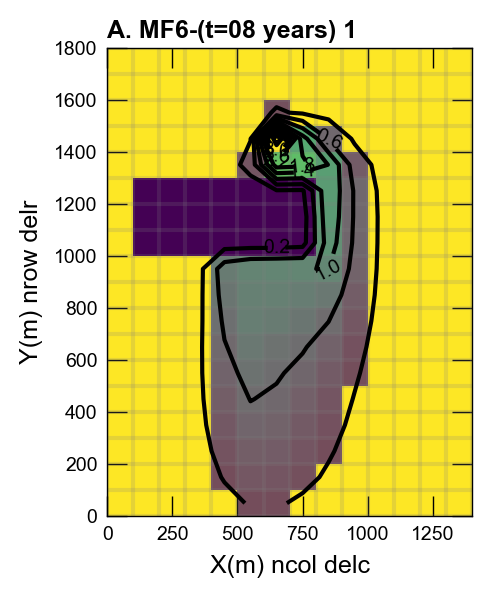

In [7]:
def scenario(idx, silent=True):
    sim = build_models(example_name, mixelm=mixelm)
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)
    if plot:
        plot_results(sim, idx)
scenario(-1, silent=True)

In [8]:
sim_ws = os.path.join (output_folder, 'ex-gwt-mt3dms-p09')    
fname = os.path.join(sim_ws, 'gwf-p09-mf6'+'.hds')  ; hdobj = flopy.utils.HeadFile(fname) ; heads = hdobj.get_data()  ; print(heads.shape)
# times = hdobj.get_times()  ; times

(1, 18, 14)


In [9]:
sim_ws = os.path.join (output_folder, 'ex-gwt-mt3dms-p09')    
fname = os.path.join(sim_ws, 'gwt-p09-mf6'+'.ucn')   # ; ucnobj = flopy.utils.UcnFile(fname)   # ; conc = ucnobj.get_alldata() 

In [10]:
# I can take from "load... again..as in ex_07 for instance.   " but I what it from here .. on"
# ... already in the function above ... "def plot_results(mf6, idx, ax=None):"